In [2]:
%config Completer.use_jedi = False

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import matplotlib.animation as animation
from IPython import display
import tqdm
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from metpy.units import units
import pickle
from netCDF4 import Dataset
import numpy as np
from tools import lonlat_to_xy
import datetime
from calendar import monthrange

# Get generic data

(array([[12., 11., 12., ..., 13., 12., 14.],
        [12., 11., 12., ..., 13., 12., 14.],
        [12., 11., 12., ..., 13., 12., 14.],
        ...,
        [12., 11., 12., ..., 13., 12., 14.],
        [12., 11., 12., ..., 13., 12., 14.],
        [12., 11., 12., ..., 13., 12., 14.]]),
 array([-4.3711388e-08,  4.9999956e-02,  9.9999957e-02,  1.4999996e-01,
         1.9999996e-01,  2.4999997e-01,  2.9999995e-01,  3.4999996e-01,
         3.9999998e-01,  4.4999996e-01,  4.9999997e-01], dtype=float32),
 <a list of 1440 BarContainer objects>)

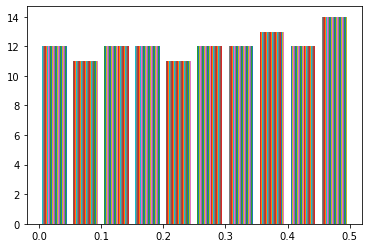

In [7]:
e0 = datetime.date(1900,1,1)

with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)

ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

area_weighting = np.cos(np.radians(ERA5_lat_grid))

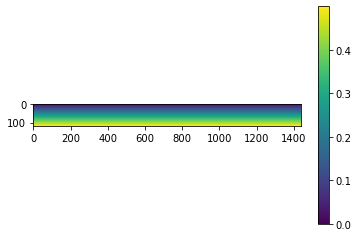

In [43]:
mon_weight = np.swapaxes(np.repeat(area_weighting[:,:,np.newaxis],31*8,axis=2).T,1,2)
plt.imshow(ERA5_lat_grid)
plt.imshow(mon_weight[-1])
plt.colorbar()

# Process annual ERA5 files

In [45]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'


for year in tqdm.trange(2021,2022):
    
    times_daily = {}
    mean_slps_daily = {}
    max_slps_daily = {}
    
#     print(year)
    with Dataset(f'/media/robbie/TOSHIBA EXT/E5/{year}.nc') as ERA5_data:

        d=0
        
        months_to_analyse = range(1,13) if year < 2021 else [1,2]
        
        for month in months_to_analyse:
            
            days_in_month = monthrange(year,month)[1]            
            
            if year != 2020:
                
                slp = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8])
                
            
            elif (year == 2020) & (month < 12):

                slp = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,0])
                
            else:            
    
                slp = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,1])
            
            
            
            
            m_weights = mon_weight[:slp.shape[0]]
            
            slp_mean = np.average(slp,
                                  weights=m_weights,
                                  axis=(1,2))
            
            slp_max = np.max(slp)
            
            t = np.array(ERA5_data['time'][d*8:(d+days_in_month)*8])
            
            
#             slp_mean = np.mean(np.split(slp_mean, 8),axis=0)
#             t = np.mean(np.split(t,8),axis=0)

            times_daily[month]=t
            mean_slps_daily[month]=slp_mean
            max_slps_daily[month] = slp_max
            
            d+=days_in_month
            
    
    mean_slp_dict = {'mean_slps':mean_slps_daily,
                     'times':times_daily}
    
    pickle.dump(mean_slp_dict, open(f'{data_dir}{year}_mean_slp.p','wb'))


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


# Get exceptional Feb data

(120,)
103222.70350171713
80
2021-02-11 00:00:00


Text(0.5, 1.0, 'Mean SLP North of 60N')

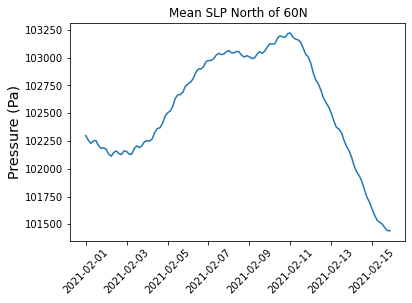

In [52]:
year = 2021

month = 2

slp_data = pickle.load(open(f'{data_dir}{year}_mean_slp.p','rb'))


times_month = slp_data['times'][month]
slps_month = slp_data['mean_slps'][month]

print(times_month.shape)

max_slp = np.max(slp_data['mean_slps'][month])

print(max_slp)

ind_max = np.where(slp_data['mean_slps'][2]==max_slp)[0][0]

print(ind_max)

t0 = datetime.datetime(1900,1,1)

real_times = [t0 + datetime.timedelta(hours=int(s)) for s in slp_data['times'][2]]

print(real_times[ind_max])

plt.plot(real_times,slps_month)
plt.xticks(rotation=45)
plt.ylabel('Pressure (Pa)',fontsize='x-large')
plt.title('Mean SLP North of 60N')

100%|██████████| 29/29 [00:00<00:00, 3500.28it/s]


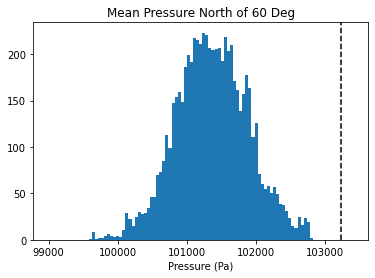

In [56]:
all_slp = []

month = 2

max_slps_list = []

rec_21 = max_slp

for year in tqdm.trange(1992,2021):

    slp_data = pickle.load(open(f'{data_dir}{year}_mean_slp.p','rb'))

    slp_for_month = list(slp_data['mean_slps'][month])
    
    max_slp_m = np.max(slp_for_month)
    
    max_slps_list.append(max_slp_m)
    
    if max_slp > rec_21:
        print(year)
        print(max_slp)
    
    all_slp += slp_for_month
    
    
plt.axvline(x=rec_21,color='k',ls='--')
plt.hist(all_slp,bins=np.linspace(99000,103400,100))
plt.title('Mean Pressure North of 60 Deg')
plt.xlabel('Pressure (Pa)')
plt.show()

Text(0.5, 0, 'Year')

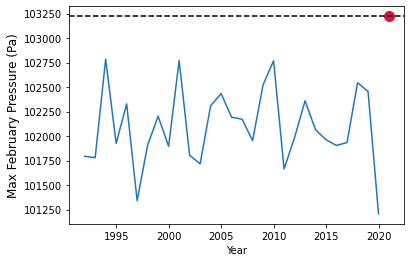

In [57]:
plt.plot(range(1992,2021),max_slps_list)
plt.plot(2021,rec_21,marker='o', color='crimson',markersize=10)
plt.axhline(rec_21,color='k',ls='--')
plt.ylabel('Max February Pressure (Pa)', fontsize='large')
plt.xlabel('Year')